In [28]:
!pip install --upgrade scikit-learn tensorflow matplotlib joblib


In [30]:
# imports
import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

from tensorflow.keras.datasets import fashion_mnist
import joblib

%matplotlib inline


In [5]:
# load data
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
print("Shapes:", X_train.shape, y_train.shape, X_test.shape, y_test.shape)

class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Shapes: (60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


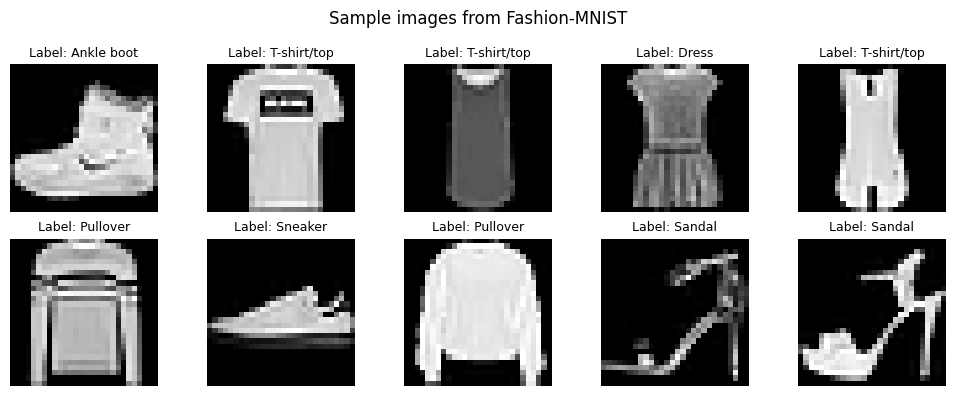

In [7]:
# show the first 10 training images (2x5 grid)
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i], cmap='gray')
    ax.set_title(f'Label: {class_names[y_train[i]]}', fontsize=9)
    ax.axis('off')

plt.suptitle('Sample images from Fashion-MNIST', fontsize=12)
plt.tight_layout()
plt.show()


In [12]:
# flatten pixels and scale to [0,1]
X_train_flat = X_train.reshape(-1, 28*28).astype("float32") / 255.0
X_test_flat  = X_test.reshape(-1, 28*28).astype("float32") / 255.0

# Optional: create a small validation split from the training set
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train_flat, y_train, test_size=0.10, stratify=y_train, random_state=42)
print("Train_sub shape:", X_train_sub.shape, "Val shape:", X_val.shape)


Train_sub shape: (54000, 784) Val shape: (6000, 784)


In [14]:
# instantiate & train a Decision Tree
dt = DecisionTreeClassifier(
    criterion="gini",
    max_depth=40,         # reasonable starting cap
    min_samples_leaf=5,   # avoid tiny leaves
    random_state=42
)

t0 = time.time()
dt.fit(X_train_sub, y_train_sub)
t1 = time.time()
print(f"Trained DecisionTree in {t1-t0:.2f} seconds")


Trained DecisionTree in 68.70 seconds


In [15]:
# Cell 6: quick accuracy checks
for name, X, y in [('Validation', X_val, y_val), ('Test', X_test_flat, y_test)]:
    y_pred = dt.predict(X)
    print(f"{name} accuracy: {accuracy_score(y, y_pred):.4f}")


Validation accuracy: 0.8103
Test accuracy: 0.8048


              precision    recall  f1-score   support

 T-shirt/top       0.75      0.77      0.76      1000
     Trouser       0.96      0.95      0.96      1000
    Pullover       0.67      0.69      0.68      1000
       Dress       0.82      0.80      0.81      1000
        Coat       0.68      0.68      0.68      1000
      Sandal       0.91      0.90      0.90      1000
       Shirt       0.56      0.55      0.56      1000
     Sneaker       0.88      0.89      0.88      1000
         Bag       0.93      0.91      0.92      1000
  Ankle boot       0.90      0.91      0.91      1000

    accuracy                           0.80     10000
   macro avg       0.81      0.80      0.81     10000
weighted avg       0.81      0.80      0.81     10000



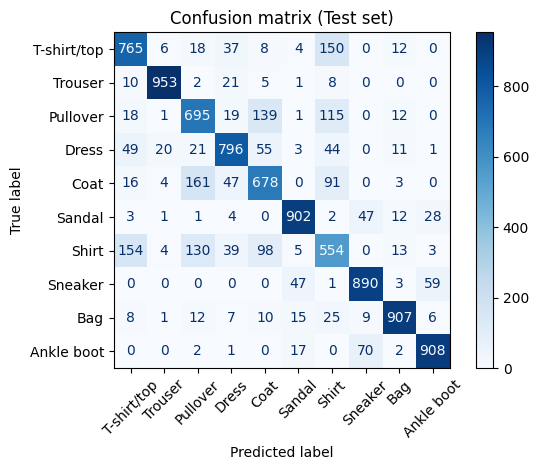

In [16]:
# classification report & confusion matrix on test set
y_test_pred = dt.predict(X_test_flat)
print(classification_report(y_test, y_test_pred, target_names=class_names))

# Confusion matrix (visual)
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_test_pred, display_labels=class_names, xticks_rotation=45, cmap='Blues', normalize=None)
plt.title("Confusion matrix (Test set)")
plt.tight_layout()
plt.show()


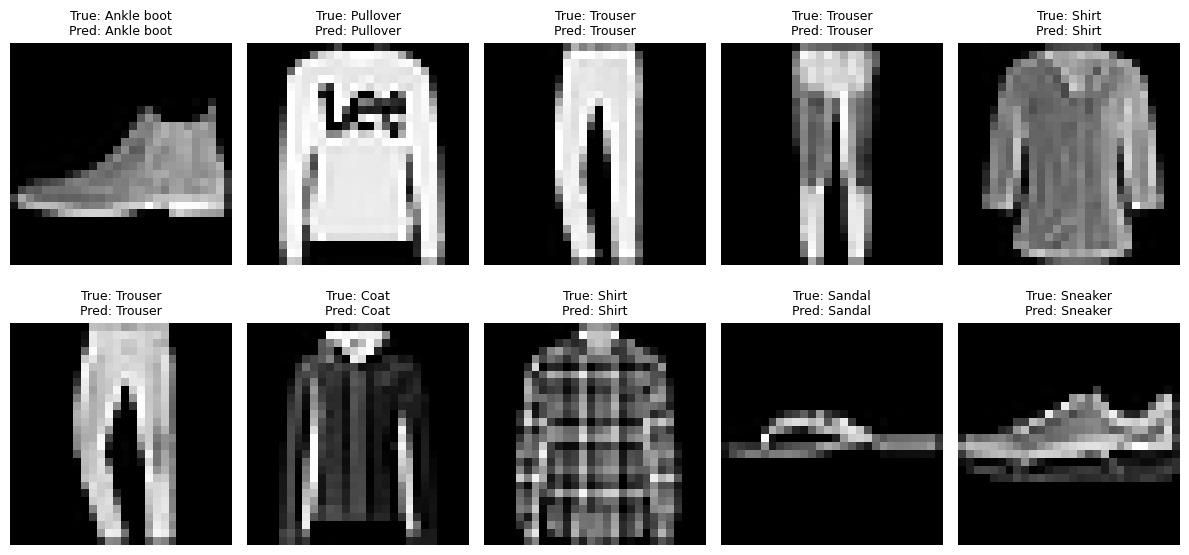

In [20]:
# show 10 test images with true & predicted labels
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(X_test[i].reshape(28, 28), cmap='gray')
    ax.set_title(f"True: {class_names[y_test[i]]}\nPred: {class_names[y_test_pred[i]]}", fontsize=9)
    ax.axis('off')
plt.tight_layout()
plt.show()


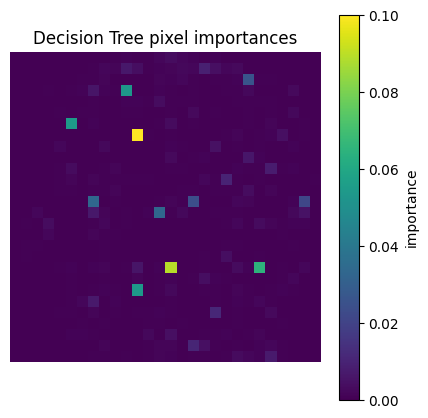

In [22]:
# feature importances as 28x28 image
importances = dt.feature_importances_
imp_img = importances.reshape(28, 28)

plt.figure(figsize=(5, 5))
plt.imshow(imp_img, interpolation='nearest')
plt.title("Decision Tree pixel importances")
plt.colorbar(label='importance')
plt.axis('off')
plt.show()


In [24]:
# GridSearch (small grid); adjust for your CPU and patience
param_grid = {
    "max_depth": [10, 20, 30, 40, None],
    "min_samples_leaf": [1, 2, 5, 10]
}

gs = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

# Use the smaller training subset to speed this up
gs.fit(X_train_sub, y_train_sub)
print("Best params:", gs.best_params_)
best_dt = gs.best_estimator_
print("Validation best CV:", gs.best_score_)
print("Test accuracy (best):", accuracy_score(y_test, best_dt.predict(X_test_flat)))


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params: {'max_depth': 10, 'min_samples_leaf': 5}
Validation best CV: 0.8046481481481482
Test accuracy (best): 0.7999


In [25]:
# quick Random Forest (may be slower but usually much more accurate)
rf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
t0 = time.time()
rf.fit(X_train_sub, y_train_sub)
t1 = time.time()
print(f"RandomForest trained in {t1-t0:.2f}s - Test acc: {accuracy_score(y_test, rf.predict(X_test_flat)):.4f}")


RandomForest trained in 24.94s - Test acc: 0.8746
